![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

# Aprendizaje Automático P64

# Practica 02


## Redes Neuronales Problemas Multiclase y Optimización (fine tunning)

## Fase 2: Optimización de una red neuronal para clasificación multiclase con imágenes 

## Autor: Diego Tapia


### Importación de librerias

In [3]:

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 

from time import time
from datetime import datetime, timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config   

print("Módulos y clases importados")

Módulos y clases importados


### Carga del dataset

Se carga el dataset CIFAR10 de la libreria de keras

In [22]:
from tensorflow.keras.datasets import cifar10
cifar10.load_data()
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Transformación de los datos

Se transforman las imágenes para ser usadas en una red neuronal clásica 

In [5]:
# Normalizamos tanto X_train como X_test, en este caso de forma sencilla porque los valores de los pixeles van de 0 a 255.
x_train = X_train/255
x_test = X_test/255
print("Normalización lista!")

#Ejemplo para verificar
print('x:',X_test[9999,1,1,1])
print("""x':""",x_test[9999,1,1,1])

Normalización lista!
x: 89
x': 0.34901960784313724


In [6]:
#Para transformar X en estructura clásica de ML (2D) para aplicar técnicas como SVM, Redes Neuronales Densas, KNN, etc.
X_trainReshapeImageRow=x_train.reshape((x_train.shape[0],3072))
print(X_trainReshapeImageRow.shape)
X_testReshapeImageRow=x_test.reshape((x_test.shape[0],3072))
print(X_testReshapeImageRow.shape)

(50000, 3072)
(10000, 3072)


## Optimización

### 1.Parámetros de compilación

En este paso se ajustará los valores de: batch_size, epochs y optimizer. El objetivo es encontrar la mejor combinación entre estos parámetros.

In [7]:
#Función para convertir el tiempo de segundos al formato de días, horas, minutos y segundos.
def GetTime(gs_time):
    sec=timedelta(seconds=gs_time)
    d = datetime(1,1,1) + sec
    tiempoTotal=("%d días: %d horas: %d min: %d seg" % (d.day-1, d.hour, d.minute, d.second))
    return tiempoTotal

In [8]:
# Creacion del pipeline (opcional)

pipe = Pipeline(
    steps=[]
)

In [9]:
def create_model():


  model = Sequential([
      Dense(32, input_dim=X_trainReshapeImageRow.shape[1], activation='relu'),
      Dense(10, activation='softmax')
  ])
  #compilamos el modelo
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  return model

Se crea listas que contienen los valores de los parámetros que se busca optimizar 

In [10]:
batch_size = [32,64,128,256]
epochs = [10,25,50,77] 
optimizer = ['RMSprop','Adam']


#parámetros que queremos probar, y sus valores 
parameters = {'modelNN__batch_size': batch_size,
             'modelNN__epochs': epochs,
             'modelNN__optimizer': optimizer}

estimator = KerasClassifier(model=create_model, verbose=0)

pipe.steps.append(['modelNN',estimator])

print(pipe)

Pipeline(steps=[['modelNN',
                 KerasClassifier(model=<function create_model at 0x000002A2CF440790>, verbose=0)]])


Se empieza a buscar la mejor combinación de parámetros con la función ```GridSearchCV```

In [11]:
# se toma el tiempo inicial para calcular el tiempo de ejecución 
tic = time()

grid_search = GridSearchCV(estimator=pipe, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=9, error_score='raise')

grid_result = grid_search.fit(X_trainReshapeImageRow, y_train)

print(grid_result.best_params_)


gs_time = time() - tic
print('Tiempo en segundos: ',gs_time)
tiempoTotal=GetTime(gs_time)
print('Tiempo: ',tiempoTotal)

gs1=grid_result

c:\Users\frank\Desktop\diego\ML_practica02\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


{'modelNN__batch_size': 256, 'modelNN__epochs': 77, 'modelNN__optimizer': 'RMSprop'}
Tiempo en segundos:  2928.8211238384247
Tiempo:  0 días: 0 horas: 48 min: 48 seg


In [12]:
print("Best: %f using %s" % (gs1.best_score_, gs1.best_params_))

Best: 0.369140 using {'modelNN__batch_size': 256, 'modelNN__epochs': 77, 'modelNN__optimizer': 'RMSprop'}


In [13]:
means = gs1.cv_results_['mean_test_score']
stds = gs1.cv_results_['std_test_score']
params = gs1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.244040 (0.074066) with: {'modelNN__batch_size': 32, 'modelNN__epochs': 10, 'modelNN__optimizer': 'RMSprop'}
0.267360 (0.024362) with: {'modelNN__batch_size': 32, 'modelNN__epochs': 10, 'modelNN__optimizer': 'Adam'}
0.211420 (0.076261) with: {'modelNN__batch_size': 32, 'modelNN__epochs': 25, 'modelNN__optimizer': 'RMSprop'}
0.230220 (0.057712) with: {'modelNN__batch_size': 32, 'modelNN__epochs': 25, 'modelNN__optimizer': 'Adam'}
0.286040 (0.065716) with: {'modelNN__batch_size': 32, 'modelNN__epochs': 50, 'modelNN__optimizer': 'RMSprop'}
0.240180 (0.074462) with: {'modelNN__batch_size': 32, 'modelNN__epochs': 50, 'modelNN__optimizer': 'Adam'}
0.201000 (0.059475) with: {'modelNN__batch_size': 32, 'modelNN__epochs': 77, 'modelNN__optimizer': 'RMSprop'}
0.231220 (0.054757) with: {'modelNN__batch_size': 32, 'modelNN__epochs': 77, 'modelNN__optimizer': 'Adam'}
0.204120 (0.069341) with: {'modelNN__batch_size': 64, 'modelNN__epochs': 10, 'modelNN__optimizer': 'RMSprop'}
0.290140 (0.049333) wi

###  2. Densidad de las capas de neuronas y regularización de Dropout
En este paso se ajusta la cantidad (densidad) de neuronas en las capas de la red. También, en este paso se ajusta los valores de dropout en las capas


Se crea el modelo de red neuronal, para la optimizacion de las capas se usa el estimador "RMSProp"  que fue mejor que adam en la busqueda del mejores parametros de compilación

In [36]:
pipe = Pipeline(
    steps=[]
)



def create_model_op(l1,l2,dr):
    model = Sequential([
        Dense(l1, input_dim=X_trainReshapeImageRow.shape[1], activation='relu'),
        Dropout(dr),
        Dense(l2, activation='relu'),
        Dropout(dr),
        # Capa de salida
        Dense(10, activation='softmax')
    ])

    
    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer='RMSprop', 
        metrics=['accuracy'])
    
    return model





Se definen los valores de las capas y el dropout, para el Clasificador usamos los parametros de compilación óptimos encontrados en el paso anterior (epochs, batch_size)

In [37]:
l1=[16, 32, 48]
l2=[16, 32, 48]
dr=[0, 0.2, 0.35]

parameters = {'modelNN__l1':l1,
            'modelNN__l2':l2,
            'modelNN__dr':dr}


estimator = KerasClassifier(model=create_model_op, verbose=0, batch_size=256, epochs=75, l1=16, l2=16, dr=0.2)

pipe.steps.append(['modelNN',estimator])

print(pipe)

Pipeline(steps=[['modelNN',
                 KerasClassifier(batch_size=256, dr=0.2, epochs=75, l1=16, l2=16, model=<function create_model_op at 0x000002A38264F400>, verbose=0)]])


In [38]:
tic = time()

grid_search = GridSearchCV(estimator=pipe, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=10)
grid_result = grid_search.fit(X_trainReshapeImageRow, y_train)


gs_time1 = time() - tic
print('Tiempo en segundos: ',gs_time1)
tiempoTotal=GetTime(gs_time1)
print('Tiempo: ',tiempoTotal)

gs2=grid_result

print("Best: %f using %s" % (gs2.best_score_, gs2.best_params_))

c:\Users\frank\Desktop\diego\ML_practica02\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tiempo en segundos:  2178.6005222797394
Tiempo:  0 días: 0 horas: 36 min: 18 seg
Best: 0.432040 using {'modelNN__dr': 0, 'modelNN__l1': 48, 'modelNN__l2': 48}


In [39]:
means = gs2.cv_results_['mean_test_score']
stds = gs2.cv_results_['std_test_score']
params = gs2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.326860 (0.054841) with: {'modelNN__dr': 0, 'modelNN__l1': 16, 'modelNN__l2': 16}
0.345060 (0.018023) with: {'modelNN__dr': 0, 'modelNN__l1': 16, 'modelNN__l2': 32}
0.297020 (0.061392) with: {'modelNN__dr': 0, 'modelNN__l1': 16, 'modelNN__l2': 48}
0.417140 (0.015810) with: {'modelNN__dr': 0, 'modelNN__l1': 32, 'modelNN__l2': 16}
0.403720 (0.006319) with: {'modelNN__dr': 0, 'modelNN__l1': 32, 'modelNN__l2': 32}
0.401380 (0.020663) with: {'modelNN__dr': 0, 'modelNN__l1': 32, 'modelNN__l2': 48}
0.422420 (0.007266) with: {'modelNN__dr': 0, 'modelNN__l1': 48, 'modelNN__l2': 16}
0.420980 (0.013287) with: {'modelNN__dr': 0, 'modelNN__l1': 48, 'modelNN__l2': 32}
0.432040 (0.018295) with: {'modelNN__dr': 0, 'modelNN__l1': 48, 'modelNN__l2': 48}
0.266000 (0.051758) with: {'modelNN__dr': 0.2, 'modelNN__l1': 16, 'modelNN__l2': 16}
0.219400 (0.035643) with: {'modelNN__dr': 0.2, 'modelNN__l1': 16, 'modelNN__l2': 32}
0.279740 (0.040806) with: {'modelNN__dr': 0.2, 'modelNN__l1': 16, 'modelNN__l2': 48

### Presentación de resultados


In [40]:
cv_results= pd.DataFrame(gs2.cv_results_)
cv_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_modelNN__dr,param_modelNN__l1,param_modelNN__l2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,133.251533,1.433611,1.754579,0.642268,0,16,16,"{'modelNN__dr': 0, 'modelNN__l1': 16, 'modelNN...",0.2602,0.3979,0.3633,0.3476,0.2653,0.32686,0.054841,13
1,135.789214,2.266565,1.316015,0.407911,0,16,32,"{'modelNN__dr': 0, 'modelNN__l1': 16, 'modelNN...",0.3214,0.3316,0.3729,0.3554,0.3440,0.34506,0.018023,11
2,140.321580,1.828023,2.222942,0.253056,0,16,48,"{'modelNN__dr': 0, 'modelNN__l1': 16, 'modelNN...",0.3122,0.3671,0.2786,0.3382,0.1890,0.29702,0.061392,16


In [41]:
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results=cv_results[["mean_test_score", "std_test_score",
            "param_modelNN__l1",
            "param_modelNN__l2"
            ]]
cv_results.head(3)

,mean_test_score,std_test_score,param_modelNN__l1,param_modelNN__l2
8,0.43204,0.018295,48,48
6,0.42242,0.007266,48,16
7,0.42098,0.013287,48,32


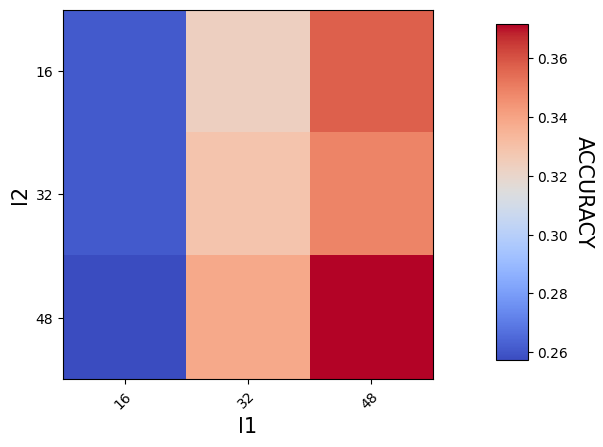

In [43]:
def make_heatmap(ax, gs, is_sh=False, make_cbar=False, cmap='GnBu'):
    results=cv_results
    scores_matrix = pd.pivot_table(data=cv_results.sort_values('mean_test_score', ascending=False),
                                   index='param_modelNN__l2', 
                                   columns='param_modelNN__l1',
                                   values='mean_test_score')
    im = ax.imshow(scores_matrix, cmap=cmap)
    z=results['mean_test_score']
    z_min, z_max = -np.abs(z).max(), np.abs(z).max()      
    ax.set_xticks(np.arange(len(l1)))
    ax.set_xticklabels([x for x in l1])
    ax.set_xlabel('l1', fontsize=15)  
    ax.set_yticks(np.arange(len(l2)))
    ax.set_yticklabels([x for x in l2])
    ax.set_ylabel('l2', fontsize=15)
    # Para girar las etiquetas de las marcas y establecer su alineación
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")  
    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel('ACCURACY', rotation=-90, va="bottom",
                           fontsize=15)

fig, axes = plt.subplots(ncols=1, sharey=True)
ax2 = axes

make_heatmap(ax2, gs2, make_cbar=True, cmap='coolwarm')
#Otros valores de colormaps: 'GnBu', 'RdBu', 'viridis', 'cividis'

#ax2.set_title('Tiempo = '+tiempoTotal, fontsize=15)
plt.show()